In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "allegro/herbert-base-cased"

In [32]:
class TransformerClassifier(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(self.transformer.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output).squeeze(-1)


In [33]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item


In [ ]:
def evaluate_transformer_model(model_path, data_path, max_len=256, batch_size=16, category_col='category'):
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    df = pd.read_csv(data_path).dropna()

    texts = df['text'].tolist()
    labels = df['label'].values
    categories = df[category_col].values

    dataset = TextDataset(texts, labels, tokenizer, max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    model = TransformerClassifier(MODEL_NAME)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels_batch = batch['labels'].to(DEVICE)

            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for HerBERT - Raw Data Extreme Cases Dataset")
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve for HerBERT - Raw Data Extreme Cases Dataset")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    correct_mask = (all_preds == all_labels)
    correct_categories = categories[correct_mask]

    unique_cats = sorted(np.unique(categories))
    counts = [np.sum(correct_categories == cat) for cat in unique_cats]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=unique_cats, y=counts, palette="magma")
    plt.xlabel("Case Category")
    plt.ylabel("Correct Predictions")
    plt.title("Correct Predictions per Category for HerBERT Transformer Model")
    plt.grid(True, axis='y')
    plt.xticks(ticks=range(len(unique_cats)), labels=[str(c) for c in unique_cats])

    for i, count in enumerate(counts):
        plt.text(i, count + 0.2, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.show()

    print("\n--- Summary of Correct Predictions per Category ---")
    for cat in unique_cats:
        total = np.sum(categories == cat)
        correct = np.sum((categories == cat) & (all_preds == all_labels))
        print(f"Kategoria {cat}: poprawnie {correct} na {total}")

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy:  0.3563
Precision: 0.5797
Recall:    0.3252
F1-score:  0.4167
ROC AUC:   0.2724

Classification Report:
               precision    recall  f1-score   support

         0.0       0.21      0.43      0.28        51
         1.0       0.58      0.33      0.42       123

    accuracy                           0.36       174
   macro avg       0.39      0.38      0.35       174
weighted avg       0.47      0.36      0.38       174



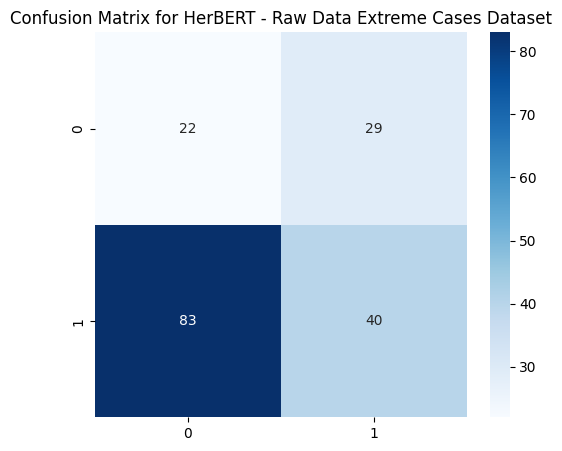

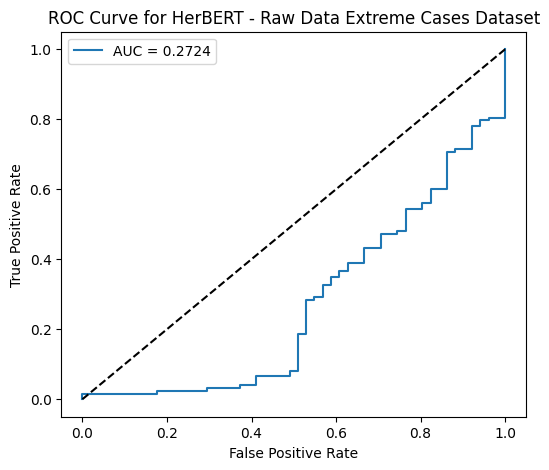

<ipython-input-49-79ffd80ce306>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_cats, y=counts, palette="magma")


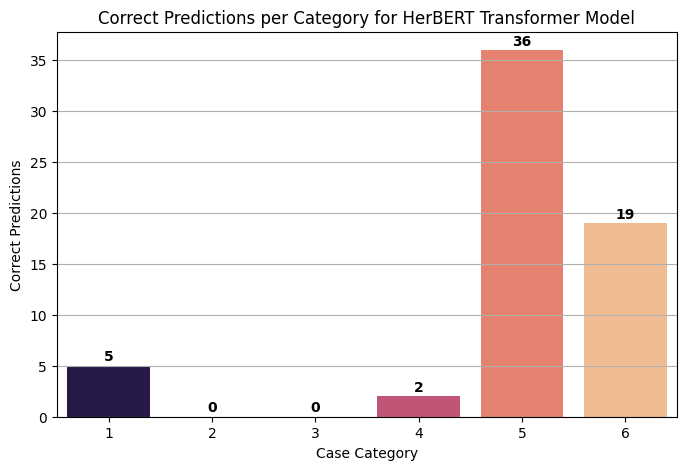


--- Summary of Correct Predictions per Category ---
Kategoria 1: poprawnie 5 na 24
Kategoria 2: poprawnie 0 na 25
Kategoria 3: poprawnie 0 na 25
Kategoria 4: poprawnie 2 na 25
Kategoria 5: poprawnie 36 na 50
Kategoria 6: poprawnie 19 na 25


In [50]:
evaluate_transformer_model(
    model_path="best_model.pt",
    data_path="extreme_examples_raw.csv",
    max_len=256,
    batch_size=16
)